<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Базовый поток. Весна 2021</b></h3>

# Сегментация изображений

В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов. 

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>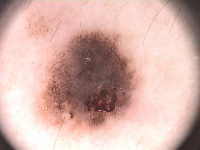</td><td>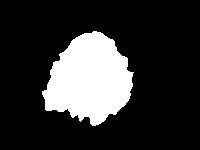</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [1]:
!gdown https://drive.google.com/uc?id=1D5kZvea81dGRnmCXXolNJ4TL-MDksti7 -O PH2Dataset.rar

#! wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar

#альтернативная ссылка на данные: https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar

Downloading...
From: https://drive.google.com/uc?id=1D5kZvea81dGRnmCXXolNJ4TL-MDksti7
To: /content/PH2Dataset.rar
100% 116M/116M [00:00<00:00, 151MB/s]


In [2]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [3]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [4]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [5]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [6]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

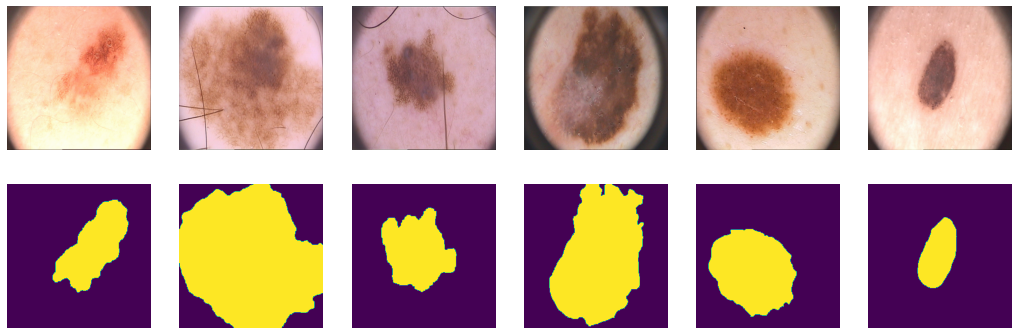

In [7]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [8]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [150, 175])

In [9]:
print(len(tr), len(val), len(ts))

150 25 25


#### PyTorch DataLoader

In [10]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [11]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

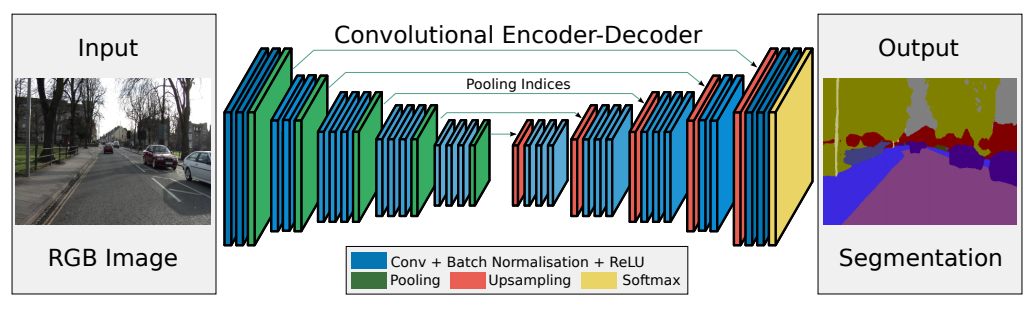

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [13]:
class SegNet(nn.Module):
    def __init__(self, N=64):
        # N is number of activation cards after the first layer
        super().__init__()

        # encoder (VGG16 conv layers)
        self.enc_conv0 = self.enc_conv_layer(3, N)
        self.pool0 = nn.MaxPool2d(2, stride=2, return_indices=True) # 256 -> 128

        self.enc_conv1 = self.enc_conv_layer(N, N*2)
        self.pool1 = nn.MaxPool2d(2, stride=2, return_indices=True) # 128 -> 64

        self.enc_conv2 = self.enc_conv_layer(N*2, N*4)
        self.pool2 = nn.MaxPool2d(2, stride=2, return_indices=True) # 64 -> 32

        self.enc_conv3 = self.enc_conv_layer(N*4, N*8)
        self.pool3 = nn.MaxPool2d(2, stride=2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = self.enc_conv_layer(N*8, N*8)

        # decoder (upsampling)
        self.upsample3 = nn.MaxUnpool2d(2, stride=2) # 16 -> 32
        self.dec_conv3 = self.dec_conv_layer(N*8, N*4)

        self.upsample2 = nn.MaxUnpool2d(2, stride=2) # 32 -> 64
        self.dec_conv2 = self.dec_conv_layer(N*4, N*2)

        self.upsample1 = nn.MaxUnpool2d(2, stride=2) # 64 -> 128
        self.dec_conv1 = self.dec_conv_layer(N*2, N)

        self.upsample0 = nn.MaxUnpool2d(2, stride=2) # 128 -> 256
        self.dec_conv0 = self.dec_conv_layer(N, N)
        
        self.out = nn.Conv2d(N, 1, 3, padding=1)

    def forward(self, x):
        # encoder
        x, indices0 = self.pool0(self.enc_conv0(x))
        x, indices1 = self.pool1(self.enc_conv1(x))
        x, indices2 = self.pool2(self.enc_conv2(x))
        x, indices3 = self.pool3(self.enc_conv3(x))

        # bottleneck
        x = self.bottleneck_conv(x)

        # decoder
        x = self.dec_conv3(self.upsample3(x, indices3))
        x = self.dec_conv2(self.upsample2(x, indices2))
        x = self.dec_conv1(self.upsample1(x, indices1))
        x = self.dec_conv0(self.upsample0(x, indices0))
        x = self.out(x) # no activation
        return x

    def enc_conv_layer(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),

            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def dec_conv_layer(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, in_channels, 3, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),

            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [14]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  #

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [15]:
def bce_loss(y_real, y_pred):
    loss = y_pred - y_real * y_pred + (1 + (-y_pred).exp()).log()
    return torch.sum(loss) / len(y_real)

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [16]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, draw=5):
    model.to(device)
    loss_history = []
    tick = time()

    for epoch in range(epochs):
        print('\n* Epoch %d/%d' % (epoch+1, epochs))
        avg_loss = 0
        model.train()
        for X_batch, Y_batch in data_tr:
            X_batch = torch.tensor(X_batch).to(device)
            Y_batch = torch.tensor(Y_batch).to(device)

            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred)
            loss.backward()
            opt.step()

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)

        loss_history.append(avg_loss)
        print(f'loss: {avg_loss}')
        
        if epoch % draw == (draw - 1):
            # show intermediate results
            model.eval()
            X_val, Y_val = next(iter(data_val))
            Y_hat = model(X_val.to(device)).detach().cpu()

            # Visualize tools
            #clear_output(wait=True)
            for k in range(6):
                plt.subplot(2, 6, k+1)
                plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
                plt.title('Real')
                plt.axis('off')

                plt.subplot(2, 6, k+7)
                plt.imshow(Y_hat[k, 0], cmap='gray')
                plt.title('Output')
                plt.axis('off')
            plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
            plt.show()

    print(f'Total time: {round((time() - tick), 2)}')
    return loss_history

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [17]:
def predict(model, data, limit=0.5):
    model.eval()  # testing mode
    Y_pred = [(model(X_batch.to(device)).sigmoid() > limit) for X_batch, _ in data]
    return np.array(Y_pred)

In [18]:
def score_model(model, metric, data, limit=0.5):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = (model(X_batch.to(device)).sigmoid() > limit)
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

In [19]:
# эта функция нужна для определения наилучшего порога принадлежности классу 0 либо 1
def find_best_limit(model, metric, data, steps):
    limits = np.linspace(0, 1, steps)
    best_limit = 0
    best_score = 0
    for limit in limits:
        score = score_model(model, metric, data, limit=limit)
        if score > best_score:
            best_score = score
            best_limit = limit
    return best_limit

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [ ]:
model = SegNet().to(device)
max_epochs = 50
optim = torch.optim.AdamW(model.parameters())

In [ ]:
torch.cuda.empty_cache()
train(model, optim, bce_loss, max_epochs, data_tr, data_val)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
torch.save(model, '/content/gdrive/MyDrive/SavedModels/SemanticSegmentation/SegNet.pt')

In [ ]:
limit = find_best_limit(model, iou_pytorch, data_val, 50)
print(f'Best limit is equal to {round(limit, 3)}')

Best limit is equal to 0.531


In [ ]:
score = score_model(model, iou_pytorch, data_ts, limit=limit)
print(f'The score is equal to {round(score, 3)}')

The score is equal to 0.736


Ответьте себе на вопрос: не переобучается ли моя модель?

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [25]:
def dice_loss(y_real, y_pred):
    SMOOTH = 1e-8
    y_pred = y_pred.sigmoid()
    num = 2 * y_real * y_pred
    den = y_real + y_pred
    frac = (num + SMOOTH)/(den + SMOOTH)
    res = 1 - frac.sum() / (256 * 256 * len(y_real))
    return res

Альтернативаня формула была взята в данной [статье](https://arxiv.org/pdf/1911.02855.pdf).

In [41]:
def dice_loss_alt(y_real, y_pred):
    SMOOTH = 1e-8
    y_pred = y_pred.sigmoid()
    num = (2 * y_real * y_pred).sum()
    den = (y_real * y_real).sum() + (y_pred * y_pred).sum()
    return 1 - (num + SMOOTH) / (den + SMOOTH)

Проводим тестирование:

In [ ]:
model_dice = SegNet()

max_epochs = 50
optimaizer = optim.AdamW(model_dice.parameters())
train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
torch.save(model_dice, '/content/gdrive/MyDrive/SavedModels/SemanticSegmentation/SegNet_DiceLoss.pt')

In [ ]:
limit = find_best_limit(model_dice, iou_pytorch, data_val, 50)
print(f'Best limit is equal to {round(limit, 3)}')

Best limit is equal to 0.98


In [ ]:
score_model(model_dice, iou_pytorch, data_val, limit=limit)

0.17999999225139618

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [32]:
def focal_loss(y_real, y_pred, eps=1e-8, gamma=2):
    y_pred =  y_pred.sigmoid() # hint: torch.clamp
    loss = (1 - y_pred).float_power(gamma) * y_real * (y_pred + eps).log() + (1 - y_real) * (1 - y_pred + eps).log()
    return - loss.sum()


* Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


loss: 750779.473369526
epoch time: 6.05 sec

* Epoch 2/20
loss: 471787.236299376
epoch time: 5.64 sec

* Epoch 3/20
loss: 340578.1728995084
epoch time: 5.65 sec

* Epoch 4/20
loss: 287076.49963962426
epoch time: 5.64 sec

* Epoch 5/20
loss: 246782.9447874507
epoch time: 5.66 sec


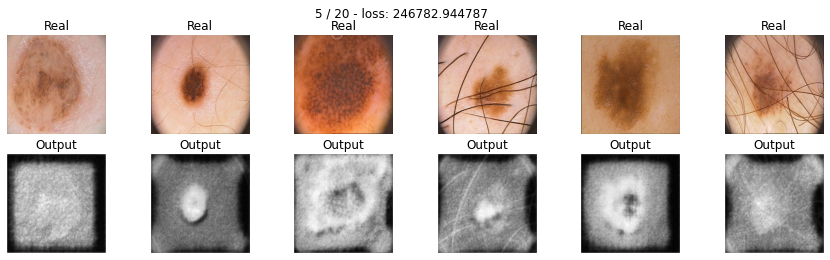


* Epoch 6/20
loss: 244565.7398501135
epoch time: 5.64 sec

* Epoch 7/20
loss: 227917.67266082152
epoch time: 5.65 sec

* Epoch 8/20
loss: 228894.09078272956
epoch time: 5.65 sec

* Epoch 9/20
loss: 250709.622192908
epoch time: 5.66 sec

* Epoch 10/20
loss: 226956.19604529708
epoch time: 5.68 sec


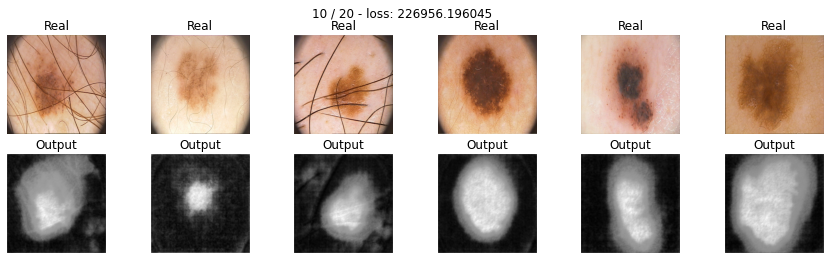


* Epoch 11/20
loss: 199573.12634478818
epoch time: 5.68 sec

* Epoch 12/20
loss: 202236.5116498265
epoch time: 5.67 sec

* Epoch 13/20
loss: 190674.6073953646
epoch time: 5.67 sec

* Epoch 14/20
loss: 209071.8611094961
epoch time: 5.68 sec

* Epoch 15/20
loss: 215269.06640442167
epoch time: 5.69 sec


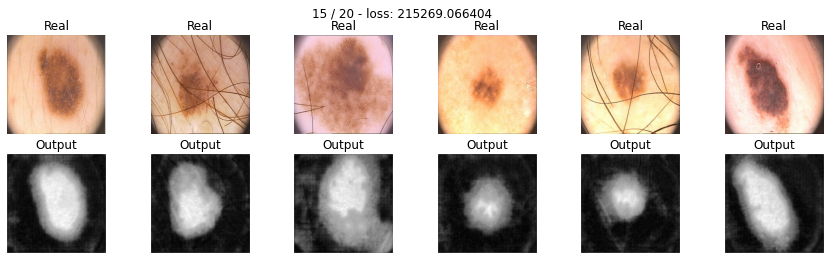


* Epoch 16/20
loss: 220430.28060228872
epoch time: 5.68 sec

* Epoch 17/20
loss: 219761.39188136486
epoch time: 5.68 sec

* Epoch 18/20
loss: 192715.7535067238
epoch time: 5.68 sec

* Epoch 19/20
loss: 203535.3377321018
epoch time: 5.69 sec

* Epoch 20/20
loss: 192972.23080727106
epoch time: 5.69 sec


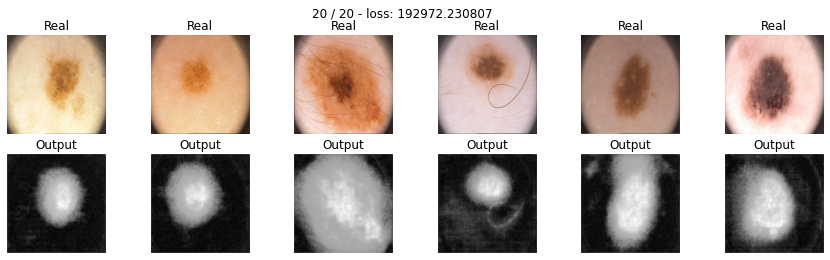

In [ ]:
model_focal = SegNet().to(device)

max_epochs = 20
optimaizer = optim.AdamW(model_focal.parameters())
train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val)

In [ ]:
torch.save(model_focal, '/content/gdrive/MyDrive/SavedModels/SemanticSegmentation/SegNet_FocalLoss.pt')

In [ ]:
limit = find_best_limit(model_focal, iou_pytorch, data_val, 50)
print(f'Best limit is equal to {round(limit, 3)}')

Best limit is equal to 0.469


In [ ]:
score_model(model_focal, iou_pytorch, data_ts)

0.6240000128746033

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

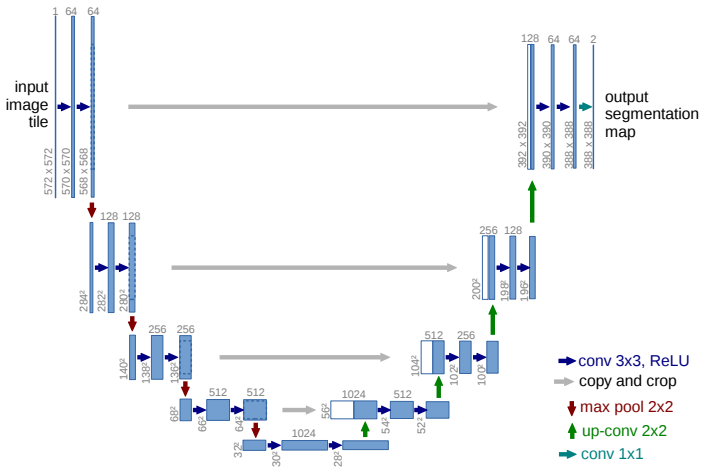

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [35]:
class UNet(nn.Module):
    def __init__(self, N=64):
        # N is number of activation cards after the first layer
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = self.conv_layer(3, N)
        self.pool0 = nn.MaxPool2d(2, stride=2) # 256 -> 128

        self.enc_conv1 = self.conv_layer(N, N*2)
        self.pool1 = nn.MaxPool2d(2, stride=2) # 128 -> 64

        self.enc_conv2 = self.conv_layer(N*2, N*4)
        self.pool2 = nn.MaxPool2d(2, stride=2) # 64 -> 32

        self.enc_conv3 = self.conv_layer(N*4, N*8)
        self.pool3 = nn.MaxPool2d(2, stride=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = self.conv_layer(N*8, N*8)

        # decoder (upsampling)
        self.upsample3 = nn.ConvTranspose2d(N*8, N*8, 2, stride=2) # 16 -> 32
        self.dec_conv3 = self.conv_layer(N*16, N*4)

        self.upsample2 = nn.ConvTranspose2d(N*4, N*4, 2, stride=2) # 32 -> 64
        self.dec_conv2 = self.conv_layer(N*8, N*2)

        self.upsample1 = nn.ConvTranspose2d(N*2, N*2, 2, stride=2) # 64 -> 128
        self.dec_conv1 = self.conv_layer(N*4, N)

        self.upsample0 = nn.ConvTranspose2d(N, N, 2, stride=2) # 128 -> 256
        self.dec_conv0 = self.conv_layer(N*2, N)
        
        self.out = nn.Conv2d(N, 1, 1)

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(self.pool0(e0))
        e2 = self.enc_conv2(self.pool1(e1))
        e3 = self.enc_conv3(self.pool2(e2))

        # bottleneck
        b = self.bottleneck_conv(self.pool3(e3))

        #print(f'bottleneck: {b.shape}')

        # decoder
        #print(torch.cat((self.upsample3(b), e3), dim=1).shape)
        d3 = self.dec_conv3(torch.cat((self.upsample3(b), e3), dim=1))
        #print(d3.shape)
        #print((torch.cat((self.upsample2(b), e2), dim=1)).shape)
        d2 = self.dec_conv2(torch.cat((self.upsample2(d3), e2), dim=1))
        d1 = self.dec_conv1(torch.cat((self.upsample1(d2), e1), dim=1))
        d0 = self.dec_conv0(torch.cat((self.upsample0(d1), e0), dim=1)) # no activation
        return self.out(d0)

    def conv_layer(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),

            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

In [ ]:
torch.cuda.empty_cache()
model = UNet().to(device)
model.eval()

for X_batch, Y_batch in data_tr:
    X_batch = torch.tensor(X_batch).to(device)
    #Y_batch = torch.tensor(Y_batch).to(device)
    
    Y_pred = model(X_batch)
    print(Y_pred.shape)
    break

torch.Size([25, 1, 256, 256])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  



* Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


loss: 32526.7734375
epoch time: 17.15 sec

* Epoch 2/5
loss: 23085.294921875
epoch time: 16.83 sec

* Epoch 3/5
loss: 20041.994140625
epoch time: 16.78 sec

* Epoch 4/5
loss: 19873.90625
epoch time: 16.76 sec

* Epoch 5/5
loss: 17970.5546875
epoch time: 16.77 sec


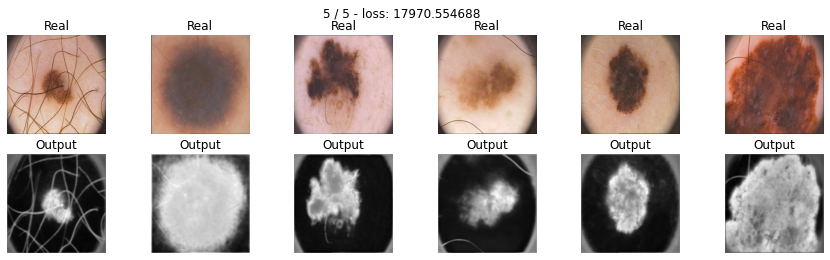

In [ ]:
torch.cuda.empty_cache()
unet_model_bce = UNet()
max_epochs = 5
optimaizer = optim.AdamW(unet_model_bce.parameters())
train(unet_model_bce, optimaizer, bce_loss, max_epochs, data_tr, data_val)


* Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


loss: 16470.072265625
epoch time: 16.9 sec

* Epoch 2/20
loss: 15710.984375
epoch time: 16.82 sec

* Epoch 3/20
loss: 15763.75390625
epoch time: 16.75 sec

* Epoch 4/20
loss: 14958.4990234375
epoch time: 16.72 sec

* Epoch 5/20
loss: 16041.1171875
epoch time: 16.72 sec


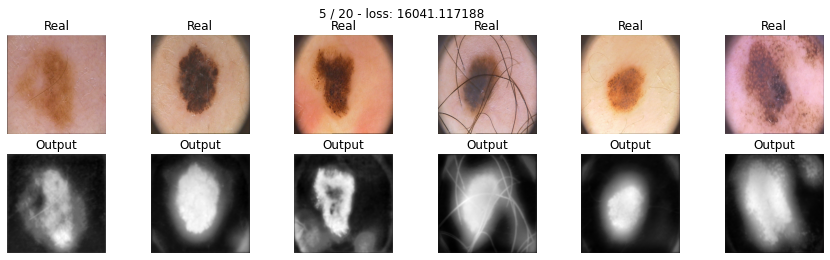


* Epoch 6/20
loss: 14823.5927734375
epoch time: 16.72 sec

* Epoch 7/20
loss: 12954.7431640625
epoch time: 16.71 sec

* Epoch 8/20
loss: 11802.38671875
epoch time: 16.71 sec

* Epoch 9/20
loss: 11359.4931640625
epoch time: 16.71 sec

* Epoch 10/20
loss: 10691.615234375
epoch time: 16.69 sec


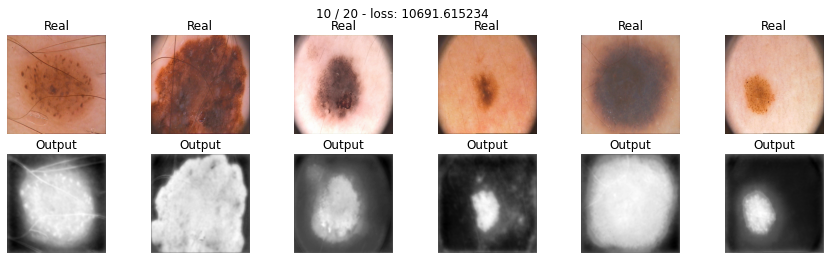


* Epoch 11/20
loss: 12098.044921875
epoch time: 16.68 sec

* Epoch 12/20
loss: 11860.0390625
epoch time: 16.69 sec

* Epoch 13/20
loss: 11197.01953125
epoch time: 16.69 sec

* Epoch 14/20
loss: 11703.8125
epoch time: 16.69 sec

* Epoch 15/20
loss: 9773.216796875
epoch time: 16.7 sec


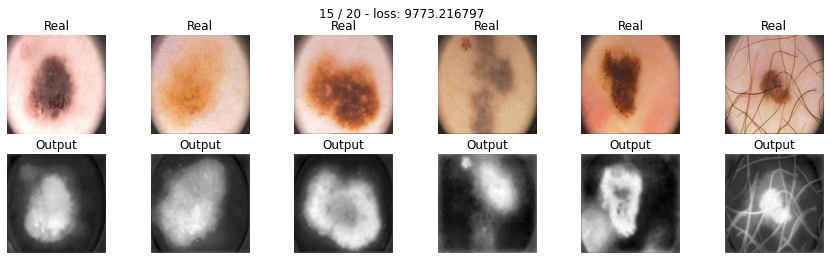


* Epoch 16/20
loss: 9587.8603515625
epoch time: 16.7 sec

* Epoch 17/20
loss: 10433.53125
epoch time: 16.68 sec

* Epoch 18/20
loss: 10412.80859375
epoch time: 16.7 sec

* Epoch 19/20
loss: 11289.5244140625
epoch time: 16.7 sec

* Epoch 20/20
loss: 9934.7734375
epoch time: 16.7 sec


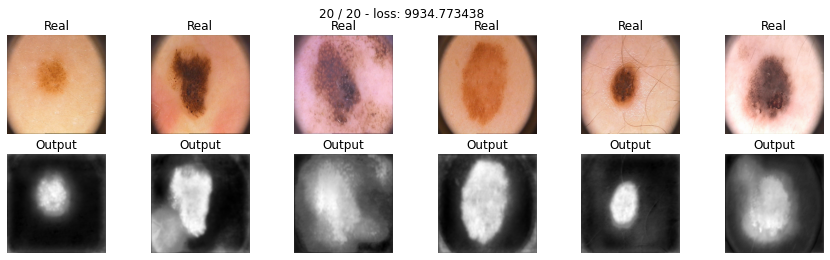



Total time: 16.7 sec


In [ ]:
train(unet_model_bce, optimaizer, bce_loss, 20, data_tr, data_val)

In [ ]:
limit = find_best_limit(unet_model_bce, iou_pytorch, data_val, 25)
print(f'Best limit is equal to {round(limit, 3)}')

Best limit is equal to 0.625


In [ ]:
score = score_model(unet_model_bce, iou_pytorch, data_ts, limit=limit)
print(f'The score is equal to {round(score, 3)}')

The score is equal to 0.592


Теперь проверьте модель UNet c функцией потерь FocalLoss. 

Сделайте вывод, какая из моделей лучше.

# Обучение моделей

In [20]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


 **SegNet**


* Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


loss: 36972.05859375

* Epoch 2/50
loss: 23141.421875

* Epoch 3/50
loss: 17420.947265625

* Epoch 4/50
loss: 16167.640625

* Epoch 5/50
loss: 14488.3974609375

* Epoch 6/50
loss: 14263.54296875

* Epoch 7/50
loss: 14798.0205078125

* Epoch 8/50
loss: 14064.6728515625

* Epoch 9/50
loss: 13918.96875

* Epoch 10/50
loss: 15277.6416015625

* Epoch 11/50
loss: 12504.515625

* Epoch 12/50
loss: 12409.7685546875

* Epoch 13/50
loss: 11651.2744140625

* Epoch 14/50
loss: 11715.73046875

* Epoch 15/50
loss: 11012.533203125

* Epoch 16/50
loss: 10735.080078125

* Epoch 17/50
loss: 12762.7177734375

* Epoch 18/50
loss: 10784.9677734375

* Epoch 19/50
loss: 12817.529296875

* Epoch 20/50
loss: 12609.26171875

* Epoch 21/50
loss: 9564.2138671875

* Epoch 22/50
loss: 11040.337890625

* Epoch 23/50
loss: 9966.3876953125

* Epoch 24/50
loss: 9412.2470703125

* Epoch 25/50
loss: 10543.576171875

* Epoch 26/50
loss: 11179.6962890625

* Epoch 27/50
loss: 13547.1640625

* Epoch 28/50
loss: 11007.8632812

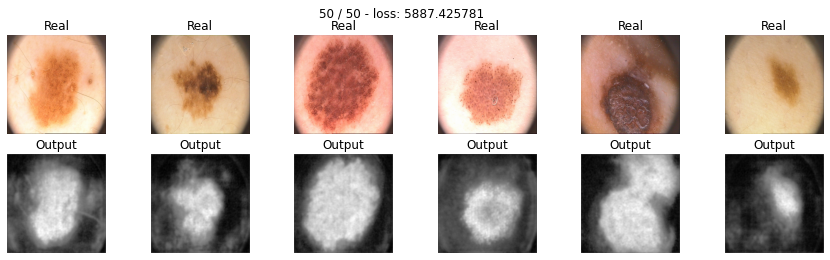

Total time: 837.61


In [21]:
segnet_bce = SegNet() # bce loss
epochs = 50
optim = torch.optim.AdamW(segnet_bce.parameters())
loss_segnet_bce = train(segnet_bce, optim, bce_loss, epochs, data_tr, data_val, draw=50)

In [22]:
torch.save(segnet_bce, '/content/gdrive/MyDrive/SavedModels/SemanticSegmentation/SegNet_BCE.pt')
np.save('/content/gdrive/MyDrive/SavedModels/SemanticSegmentation/SegNet_BCE_loss.npy', np.array(loss_segnet_bce))

In [23]:
# find best border between 0 and 1 classes through bruteforce on validation data
limit_segnet_bce = find_best_limit(segnet_bce, iou_pytorch, data_val, 25)
print(f'Best limit is equal to {round(limit_segnet_bce, 3)}')

Best limit is equal to 0.474


In [24]:
# scoring model on test data
score_segnet_bce = score_model(segnet_bce, iou_pytorch, data_ts, limit=limit_segnet_bce)
print(f'The score is equal to {round(score_segnet_bce, 3)}')

The score is equal to 0.788


In [85]:
train_score_segnet_bce = score_model(segnet_bce, iou_pytorch, data_tr, limit=limit_segnet_bce)
val_score_segnet_bce = score_model(segnet_bce, iou_pytorch, data_val, limit=limit_segnet_bce)

In [43]:
segnet_dice = SegNet() #dice_loss
epochs = 50
optim = torch.optim.AdamW(segnet_dice.parameters())
loss_segnet_dice = train(segnet_dice, optim, dice_loss_alt, epochs, data_tr, data_val, draw=5)

Output hidden; open in https://colab.research.google.com to view.

In [44]:
torch.save(segnet_dice, '/content/gdrive/MyDrive/SavedModels/SemanticSegmentation/SegNet_Dice.pt')
np.save('/content/gdrive/MyDrive/SavedModels/SemanticSegmentation/SegNet_Dice_loss.npy', np.array(loss_segnet_dice))

In [45]:
limit_segnet_dice = find_best_limit(segnet_dice, iou_pytorch, data_val, 25)
print(f'Best limit is equal to {round(limit_segnet_dice, 3)}')

Best limit is equal to 0.458


In [86]:
score_segnet_dice = score_model(segnet_dice, iou_pytorch, data_ts, limit=limit_segnet_dice)
print(f'The score is equal to {round(score_segnet_dice, 3)}')
train_score_segnet_dice = score_model(segnet_dice, iou_pytorch, data_tr, limit=limit_segnet_dice)
val_score_segnet_dice = score_model(segnet_dice, iou_pytorch, data_val, limit=limit_segnet_dice)

The score is equal to 0.764



* Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


loss: 731496.0565642206

* Epoch 2/50
loss: 391994.49760633183

* Epoch 3/50
loss: 362838.4113926831

* Epoch 4/50
loss: 284510.55767299875

* Epoch 5/50
loss: 266031.87623173406

* Epoch 6/50
loss: 287512.8914747826

* Epoch 7/50
loss: 281678.22867847676

* Epoch 8/50
loss: 232192.7936480604

* Epoch 9/50
loss: 226346.2839313004

* Epoch 10/50
loss: 210630.1679960094

* Epoch 11/50
loss: 215319.97859707376

* Epoch 12/50
loss: 213097.28682310984

* Epoch 13/50
loss: 196398.15854414133

* Epoch 14/50
loss: 213604.7749876819

* Epoch 15/50
loss: 206360.04045986707

* Epoch 16/50
loss: 196040.68855998266

* Epoch 17/50
loss: 231769.87480738186

* Epoch 18/50
loss: 235671.93761251698

* Epoch 19/50
loss: 253218.63537810493

* Epoch 20/50
loss: 222912.6646315608

* Epoch 21/50
loss: 181923.76499504212

* Epoch 22/50
loss: 226501.32497392176

* Epoch 23/50
loss: 170790.37059924827

* Epoch 24/50
loss: 171856.46639766678

* Epoch 25/50
loss: 175481.213144426

* Epoch 26/50
loss: 163018.32345

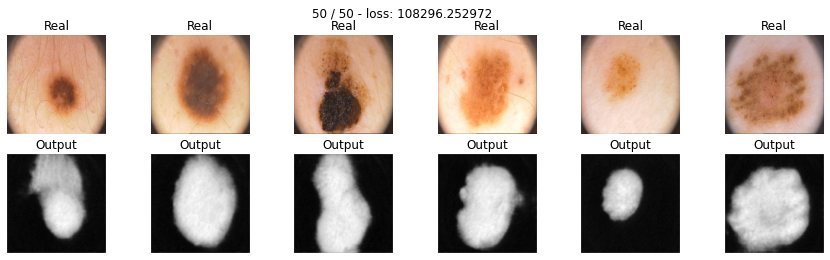

Total time: 835.06


In [33]:
segnet_focal = SegNet() #dice_loss
epochs = 50
optim = torch.optim.AdamW(segnet_focal.parameters())
loss_segnet_focal = train(segnet_focal, optim, focal_loss, epochs, data_tr, data_val, draw=50)

In [34]:
torch.save(segnet_focal, '/content/gdrive/MyDrive/SavedModels/SemanticSegmentation/SegNet_Focal.pt')
np.save('/content/gdrive/MyDrive/SavedModels/SemanticSegmentation/SegNet_Focal_loss.npy', np.array(loss_segnet_focal))

limit_segnet_focal = find_best_limit(segnet_focal, iou_pytorch, data_val, 25)
print(f'Best limit is equal to {round(limit_segnet_focal, 3)}')

score_segnet_focal = score_model(segnet_focal, iou_pytorch, data_ts, limit=limit_segnet_focal)
print(f'The score is equal to {round(score_segnet_focal, 3)}')

Best limit is equal to 0.417
The score is equal to 0.768


In [87]:
train_score_segnet_focal = score_model(segnet_focal, iou_pytorch, data_tr, limit=limit_segnet_focal)
val_score_segnet_focal = score_model(segnet_focal, iou_pytorch, data_val, limit=limit_segnet_focal)

**U-Net**


* Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


loss: 34527.48828125

* Epoch 2/50
loss: 23157.7109375

* Epoch 3/50
loss: 20489.435546875

* Epoch 4/50
loss: 18773.130859375

* Epoch 5/50
loss: 17056.94140625

* Epoch 6/50
loss: 16032.205078125

* Epoch 7/50
loss: 14933.4375

* Epoch 8/50
loss: 13812.5458984375

* Epoch 9/50
loss: 13352.521484375

* Epoch 10/50
loss: 13665.2802734375

* Epoch 11/50
loss: 14825.35546875

* Epoch 12/50
loss: 13032.1865234375

* Epoch 13/50
loss: 12338.447265625

* Epoch 14/50
loss: 11259.953125

* Epoch 15/50
loss: 11677.958984375

* Epoch 16/50
loss: 11905.8291015625

* Epoch 17/50
loss: 11752.609375

* Epoch 18/50
loss: 10738.2275390625

* Epoch 19/50
loss: 10196.572265625

* Epoch 20/50
loss: 10388.8974609375

* Epoch 21/50
loss: 9263.6484375

* Epoch 22/50
loss: 9334.4951171875

* Epoch 23/50
loss: 10823.951171875

* Epoch 24/50
loss: 10355.365234375

* Epoch 25/50
loss: 11085.01171875

* Epoch 26/50
loss: 9335.6328125

* Epoch 27/50
loss: 9528.4482421875

* Epoch 28/50
loss: 8585.005859375

* Ep

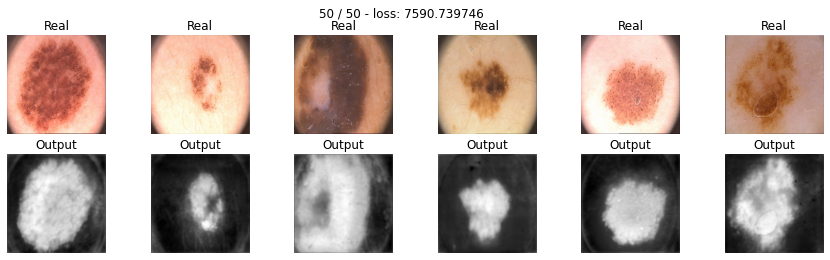

Total time: 886.18


In [36]:
unet_bce = UNet() #dice_loss
epochs = 50
optim = torch.optim.AdamW(unet_bce.parameters())
loss_unet_bce = train(unet_bce, optim, bce_loss, epochs, data_tr, data_val, draw=50)

In [73]:
torch.save(unet_bce, '/content/gdrive/MyDrive/SavedModels/SemanticSegmentation/UNet_BCE.pt')
np.save('/content/gdrive/MyDrive/SavedModels/SemanticSegmentation/UNet_BCE_loss.npy', np.array(loss_unet_bce))

limit_unet_bce = find_best_limit(unet_bce, iou_pytorch, data_val, 25)
print(f'Best limit is equal to {round(limit_unet_bce, 3)}')

score_unet_bce = score_model(unet_bce, iou_pytorch, data_ts, limit=limit_unet_bce)
print(f'The score is equal to {round(score_unet_bce, 3)}')

Best limit is equal to 0.292
The score is equal to 0.788


In [88]:
train_score_unet_bce = score_model(unet_bce, iou_pytorch, data_tr, limit=limit_unet_bce)
val_score_unet_bce = score_model(unet_bce, iou_pytorch, data_val, limit=limit_unet_bce)

In [51]:
unet_dice = UNet() #focal_loss
epochs = 50
optim = torch.optim.AdamW(unet_dice.parameters())
loss_unet_dice = train(unet_dice, optim, dice_loss_alt, epochs, data_tr, data_val, draw=5)

Output hidden; open in https://colab.research.google.com to view.

In [52]:
torch.save(unet_dice, '/content/gdrive/MyDrive/SavedModels/SemanticSegmentation/UNet_Dice.pt')
np.save('/content/gdrive/MyDrive/SavedModels/SemanticSegmentation/UNet_Dice_loss.npy', np.array(loss_unet_dice))

limit_unet_dice = find_best_limit(unet_dice, iou_pytorch, data_val, 25)
print(f'Best limit is equal to {round(limit_unet_dice, 3)}')

score_unet_dice = score_model(unet_dice, iou_pytorch, data_ts, limit=limit_unet_dice)
print(f'The score is equal to {round(score_unet_dice, 3)}')

Best limit is equal to 0.708
The score is equal to 0.744


In [89]:
train_score_unet_dice = score_model(unet_dice, iou_pytorch, data_tr, limit=limit_unet_dice)
val_score_unet_dice = score_model(unet_dice, iou_pytorch, data_val, limit=limit_unet_dice)


* Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


loss: 539821.4663845572

* Epoch 2/50
loss: 398695.79628636676

* Epoch 3/50
loss: 337251.25950518495

* Epoch 4/50
loss: 302030.2880677622

* Epoch 5/50
loss: 288174.87680502905

* Epoch 6/50
loss: 276291.2638636924

* Epoch 7/50
loss: 264665.9345504096

* Epoch 8/50
loss: 264599.6404251222

* Epoch 9/50
loss: 249650.4764220672

* Epoch 10/50
loss: 238226.19951148643

* Epoch 11/50
loss: 217298.3403287087

* Epoch 12/50
loss: 247775.18681442607

* Epoch 13/50
loss: 229508.93273332398

* Epoch 14/50
loss: 226658.1705657458

* Epoch 15/50
loss: 215029.6890719203

* Epoch 16/50
loss: 187403.16369364323

* Epoch 17/50
loss: 219583.17097489617

* Epoch 18/50
loss: 183106.13779652878

* Epoch 19/50
loss: 181427.5706594961

* Epoch 20/50
loss: 162042.7221945046

* Epoch 21/50
loss: 172859.27005670796

* Epoch 22/50
loss: 161816.58591137035

* Epoch 23/50
loss: 191122.40109817538

* Epoch 24/50
loss: 176120.94732175092

* Epoch 25/50
loss: 184890.27226513115

* Epoch 26/50
loss: 168833.377895

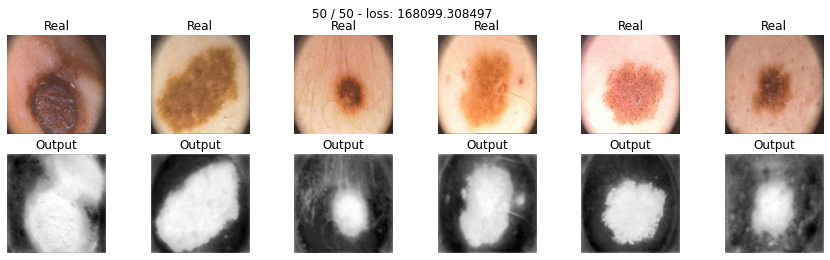

Total time: 893.07


In [38]:
unet_focal = UNet() #focal_loss
epochs = 50
optim = torch.optim.AdamW(unet_focal.parameters())
loss_unet_focal = train(unet_focal, optim, focal_loss, epochs, data_tr, data_val, draw=50)

In [39]:
torch.save(unet_focal, '/content/gdrive/MyDrive/SavedModels/SemanticSegmentation/UNet_Focal.pt')
np.save('/content/gdrive/MyDrive/SavedModels/SemanticSegmentation/UNet_Focal_loss.npy', np.array(loss_unet_focal))

limit_unet_focal = find_best_limit(unet_focal, iou_pytorch, data_val, 25)
print(f'Best limit is equal to {round(limit_unet_focal, 3)}')

score_unet_focal = score_model(unet_focal, iou_pytorch, data_ts, limit=limit_unet_focal)
print(f'The score is equal to {round(score_unet_focal, 3)}')

Best limit is equal to 0.292
The score is equal to 0.74


In [90]:
train_score_unet_focal = score_model(unet_focal, iou_pytorch, data_tr, limit=limit_unet_focal)
val_score_unet_focal = score_model(unet_focal, iou_pytorch, data_val, limit=limit_unet_focal)

# Отчет (6 баллов)


В ходе проделанной работы были реализованы все необходимые функции и архитектуры.

* Первоначальный вариант функции потерь Dice Loss не приносил должных результатов: точность на тесте составляла всего 18%. Решением проблемы стала альтернативная формула для подсчетов, приведенная в данной [статье](https://arxiv.org/pdf/1911.02855.pdf).

* Было два варианта реализации последнего слоя обеих сетей: с двумя либо с одной картой активации. Мною был выбран второй вариант. Для его реализации была написана функция подбора наулучшего порога принадлежности одному из классов. Данная функция измеряет метрику на валидационной части датасета с различными порогами, подбирая тот, что дает лучший результат.

* Модели были реализованны с изменяемым количеством параметров, которое можно задать при создании. 


**Сравнение моделей:**

Ожидалось, что результаты U-Net окажутся лучше чем у SegNet. По итогу модели показали примерно одинаковые точности, что не дает мне выделить лучшую из них.

Как мы видим из графиков, модели имеют примерно одинаковую скорость сходимости.

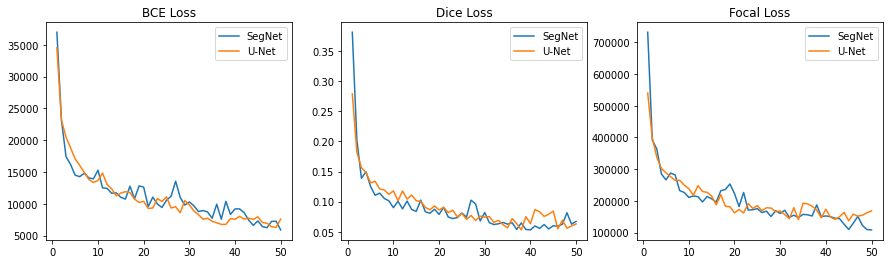

In [70]:
fig, axes = plt.subplots(1, 3)
axes[0].set_title('BCE Loss')
axes[0].plot(np.linspace(1, 50, 50), loss_segnet_bce, label='SegNet')
axes[0].plot(np.linspace(1, 50, 50), loss_unet_bce, label='U-Net')
axes[0].legend()

axes[1].set_title('Dice Loss')
axes[1].plot(np.linspace(1, 50, 50), loss_segnet_dice, label='SegNet')
axes[1].plot(np.linspace(1, 50, 50), loss_unet_dice, label='U-Net')
axes[1].legend()

axes[2].set_title('Focal Loss')
axes[2].plot(np.linspace(1, 50, 50), loss_segnet_focal, label='SegNet')
axes[2].plot(np.linspace(1, 50, 50), loss_unet_focal, label='U-Net')
axes[2].legend()

plt.show()

Лучшую точность обе модели имеют при обучении с BCE loss.

<BarContainer object of 6 artists>

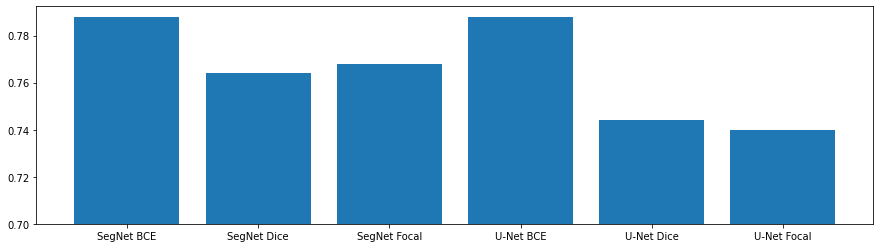

In [81]:
y = np.array([score_segnet_bce, score_segnet_dice, score_segnet_focal,
     score_unet_bce, score_unet_dice, score_unet_focal]) - 0.7

x = ['SegNet BCE', 'SegNet Dice', 'SegNet Focal',
     'U-Net BCE', 'U-Net Dice', 'U-Net Focal']

fig, ax = plt.subplots()
ax.bar(x, y, bottom=0.7)

Из приведенного ниже графика измерения метрик по всем моделям и выборкам данных можно сделать вывод, что выбор архитектуры моделей с одой картой активации на выходе был не лучшим решением.

Из-за малого количества данных тренировочная, валидационная и тестовая выборки имеют чувствительные отличия в данных. Таким образом, определние порога принадлежности классу по валидационной части датасета приводит к тому, что точность на тренировочной части в некоторых случаях ниже, чем на остальных данных, чего почти никогда не случается.

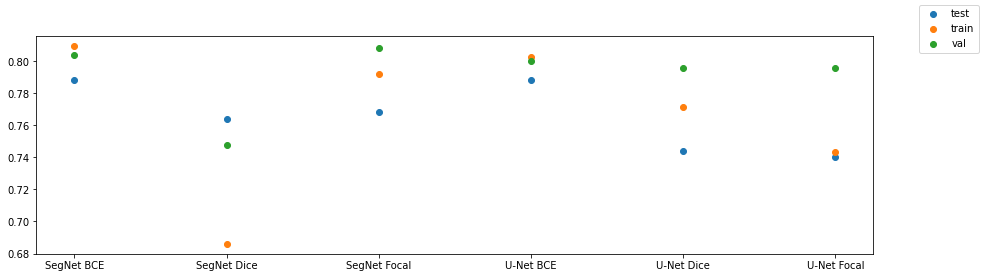

In [97]:
y = [[score_segnet_bce, score_segnet_dice, score_segnet_focal,
     score_unet_bce, score_unet_dice, score_unet_focal],
     [train_score_segnet_bce, train_score_segnet_dice, train_score_segnet_focal,
     train_score_unet_bce, train_score_unet_dice, train_score_unet_focal],
     [val_score_segnet_bce, val_score_segnet_dice, val_score_segnet_focal,
     val_score_unet_bce, val_score_unet_dice, val_score_unet_focal]]

fig, ax = plt.subplots()
ax.scatter(x, y[0], label='test')
ax.scatter(x, y[1], label='train')
ax.scatter(x, y[2], label='val')
fig.legend()

**Выводы:**

Из-за неточности моего эксперимента, описанной мною выше, не получается сделать вывод о том, какая из реализованных архитектур лучше.

Обучение обеих моделей до сходимсти для всех функций потерь просиходит примерно за одинаковое время.

Лучшей функцией потерь для обеих моделей оказалась BCE loss.

Самую чистую результирующую карту сегментации имеет SegNet, обученный при помощи Focal loss. Но при этом его результат лишь немного лучше Dice loss, который находится на последнем месте среди функций потерь для SegNet.

**Выводы о проделанной работе:**

Я смог реализовать рабочие архитектуры сверточных сетей, а также написать функции потерь для их обучения. Мною был получены полезные знания о возможных ошибках, которые могут быть получены при проведении данного эксперимента.

Теперь можно провести работу над ошибками с учетом полученного опыта:
* Так как данных мало, нужно использовать аугментации
* Реализация с двумя картами активации на выходе моделей позволила бы отслеживать возможное переобучение (так как с существующей реализвцией невозможно качественно отслеживать качество модели во время обучения)
* При описанной выше реализации будет возможным поиск оптимального количества параметров в моделях
* Так же стоит предпринять повторные попытки понять, почему первоначальная формула Dice loss не принесла ожидаемых результатов.